In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import statsmodels.api as sm
from scipy.stats import ttest_ind
import json
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind, ttest_1samp
from typing import List,Dict,Tuple,Union
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd




In [211]:
overall_df = pd.read_excel('cond_1_3rd_May_20_Sat/Satisfaction_ratings/final_Sat_Overall.xlsx')
overall_df_first_half = pd.read_excel('cond_1_3rd_May_20_Sat/Satisfaction_ratings/final_Sat_Overall_First_Half.xlsx')
overall_df_second_half = pd.read_excel('cond_1_3rd_May_20_Sat/Satisfaction_ratings/final_Sat_Overall_Second_Half.xlsx')
trials_df = pd.read_excel("stimuli_29Apr24_5_trials.xlsx")


suspense_sum = pd.read_excel('suspense_sum.xlsx')
susp_filtered_df_3rd = pd.read_excel('susp_filtered_df_3rd.xlsx')
sat_filtered_df_1st = pd.read_excel('sat_filtered_df_1st_bastien.xlsx')


In [212]:

grouped_df = overall_df.groupby(by=['game','participant'], as_index=False)

full_dataframe = pd.DataFrame()

for meta, dataframe in grouped_df: 
    dataframe.sort_values(by='pair_number', ascending=True, inplace = True)
    dataframe['count'] = dataframe['card_1'].cumsum()
    full_dataframe = pd.concat([full_dataframe, dataframe])
overall_df = full_dataframe.copy()


### Exclude bad particants with catch trial results

First, we have to re-integrate the pseudo-randomisation by game in the overall_df as the data is extracted without it

- Game 0: 1-1-1-2-2
- Game 1: 1-1-2-2-1
- Game 3: 2-2-2-1-1

- Game 7: 1-1-2-2-1
- Game 9: 2-2-2-1-1
- Game 11: 2-1-1-2-1

- Game 12: 1-1-1-2-2
- Game 14: 1-2-21-2
- Game 15: 2-2-2-1-1
- Game 16: 2-2-1-1-2

- Game 19: 1-1-2-2-1
- Game 20: 1-2-2-1-2
- Game 22: 2-2-1-1-2

- Game 25: 1-1-2-2-1
- Game 28: 2-2-1-1-2
- Game 29: 2-1-1-2-1

- Game 32: 1-2-2-1-2
- Game 33: 2-2-2-1-1
- Game 34: 2-2-1-1-2

In [213]:
#sort overall dataframe by game
overall_df.sort_values(by="game",ascending=True)


,rt,catch_response,sat_rating,trial,game,pair_number,card_1,card_2,count,catch_count,catch_count_response,expected_outcome,suspense_level,participant
30,6579,3,NaN,6,0,1,-6,1,-6,NaN,NaN,winning,low suspense,Participant1
2477,2430,3,NaN,9,0,3,-5,-4,-10,NaN,NaN,winning,low suspense,Participant28
2476,5329,0,NaN,9,0,2,1,-4,-5,NaN,NaN,winning,low suspense,Participant28
2475,1447,1,NaN,9,0,1,-6,1,-6,NaN,NaN,winning,low suspense,Participant28
2409,2425,0,0.786511,13,0,5,-4,1,-17,NaN,NaN,winning,low suspense,Participant27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,2313,0,NaN,7,34,2,-3,2,-1,NaN,NaN,losing,high suspense,Participant18
1567,3568,0,NaN,7,34,3,5,-3,4,NaN,NaN,losing,high suspense,Participant18
1568,2528,1,NaN,7,34,4,-1,3,3,NaN,NaN,losing,high suspense,Participant18
1512,1890,1,NaN,14,34,3,5,-3,4,NaN,NaN,losing,high suspense,Participant17


In [214]:
#Write function to swap cards when required accoding to game index

def number_to_ordering(number:int)->Tuple[str,str]:
    """If the number is 1, then we have the normal order (i.e. no swapping), else we reverse the columns."""
    match number:
        case 1:
            return ("card_1","card_2")
        case 2:
            return ("card_2","card_1")


def swap_cards_mod(results_dataframe:pd.DataFrame,trials_dataframe:pd.DataFrame )->pd.DataFrame:
    
    # Getting the unique games from the dataframe
    unique_games:List[int]= list(results_dataframe["game"].unique())
    
    full_data:pd.DataFrame = pd.DataFrame()
    # Iterating through the games to make choices on how to set the card choice
    for game_number in unique_games:
        # Card rules are given by the randomisation string in the trials dataframe
        randomisation_string:str = trials_dataframe.iloc[game_number]["Randomisation"]
        position_choices:List[int] = [ int(part) for part in randomisation_string if part.isnumeric()]
        
        # Adding index to the position
        position_choices:List[Tuple[int,int]] = [(iter+1 ,part) for iter,part in enumerate(position_choices)]

        # Making a copy of the data to amend to concat later
        subset_dataframe:pd.DataFrame = results_dataframe.loc[results_dataframe["game"] == game_number].copy()
        
        # Generating the conditons for the numpy select
        for pair_num, card_choice in position_choices:
            # Making a copy of the subset so we don't override
            subset_copy = subset_dataframe.copy()


            orderings:Tuple[str,str] = number_to_ordering(card_choice)

            # creating conditions for the numpy select
            swap_conditions:List[bool]= [subset_dataframe["pair_number"] == pair_num]
            swap_cond_copy:List[bool] = [subset_copy["pair_number"] == pair_num]

            # Using numpy select to perform the swap on the data.
            subset_dataframe["card_1"] = np.select(swap_conditions,[subset_dataframe[orderings[0]]],default = subset_dataframe["card_1"])
            subset_copy["card_2"] = np.select(swap_cond_copy,[subset_copy[orderings[1]]],default = subset_copy["card_2"])

            # Re-writing back
            subset_dataframe["card_2"] = subset_copy["card_2"]

        # Dataframe should now be altered, so we concatenate
        full_data = pd.concat([full_data,subset_dataframe])

    return full_data


def swap_cards(dataframe):

    swapped_df = dataframe.copy()

    for game in swapped_df ['game']:
        
        if game in [0, 6, 12]:
            for swapped_df ['pair_number'] in [4, 5]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']
        
        if game in [1, 7, 13]:
            for swapped_df ['pair_number'] in [3, 4]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']
        
        if game in [2, 8, 14]:
            for swapped_df ['pair_number'] in [2, 3]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']

        if game in [3, 9, 15]:
            for swapped_df ['pair_number'] in [1, 2, 3]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']

    
        if game in [4, 10, 16]:
            for swapped_df ['pair_number'] in [1, 2, 5]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']
        
        if game in [5, 11, 17]:
            for swapped_df ['pair_number'] in [1, 4]:
                # Swap column card_1 and card_2 for specific game and pair_number
                swapped_df['card_1'], swapped_df['card_2'] = swapped_df['card_2'], swapped_df['card_1']
        
    return swapped_df




In [215]:
#swapped dataframe has all the cards randomised according to pseudo-randomisation
swapped_df = swap_cards_mod(overall_df,trials_df)
swapped_df_first_half = swap_cards_mod(overall_df_first_half,trials_df)
swapped_df_second_half = swap_cards_mod(overall_df_second_half,trials_df)


### Calculate participant accuracy


In [216]:

def catch_test(dataframe):
    success_rates = []
    filtered_dataframes = []

    for participant in dataframe['participant'].unique():
        # Filter dataframe for the current participant and make a copy
        participant_df = dataframe[dataframe['participant'] == participant].copy()

        # Calculate conditions
        condition_1 = (participant_df['card_1'] > 0) & (participant_df['card_2'] < 0) & (participant_df['catch_response'] == 0)
        condition_2 = (participant_df['card_1'] < 0) & (participant_df['card_2'] > 0) & (participant_df['catch_response'] == 1)
        condition_3 = (participant_df['card_1'] > 0) & (participant_df['card_2'] > 0) & (participant_df['catch_response'] == 2)
        condition_4 = (participant_df['card_1'] < 0) & (participant_df['card_2'] < 0) & (participant_df['catch_response'] == 3)

        # Concatenate conditions using logical OR
        result_array = condition_1 | condition_2 | condition_3 | condition_4

        # Calculate success rate for the participant
        true_count = result_array.sum()
        success_rate = (true_count / len(participant_df)) * 100
        success_rates.append(success_rate)

        # Add success rates to the dataframe
        participant_df.loc[:, 'success_rate'] = success_rate

        # Exclude participants with success rate lower than 70%
        if success_rate >= 75:
            filtered_dataframes.append(participant_df)

    # Concatenate all filtered dataframes into a single dataframe
    filtered_dataframe = pd.concat(filtered_dataframes)

    # performing the second catch tests
    second_passers, full_grades = second_catch_test(filtered_dataframe)

    # Filtering onto those that pass the second catch tests
    filtered_dataframe = filtered_dataframe.loc[filtered_dataframe["participant"].isin(second_passers)]

    return filtered_dataframe


def second_catch_test(dataframe:pd.DataFrame, passing_grade:int=75)->Tuple[List[str],Dict[str,int]]:
    grades:Dict[str,float] = {}
    passers:List[str] = []
    # Removing the nans from the dataframe since they aren't useful
    dataframe_reduced:pd.DataFrame = dataframe.loc[~pd.isna(dataframe["catch_count"])].copy()

    # Creating the conditions for passing the catch trials, else does not pass
    passing_conditions:List[pd.Series] = [
        (dataframe_reduced["catch_count"] == dataframe_reduced["count"])&(dataframe_reduced["catch_count_response"] == 0),
        (dataframe_reduced["catch_count"] != dataframe_reduced["count"])&(dataframe_reduced["catch_count_response"] == 1)
    ]
    passing_choices:List[bool] = [True,True]
    dataframe_reduced["passed_catch_trial"] = np.select(passing_conditions,passing_choices,default=False)

    # Grouping by the participants - there are multiple catch trials per participant and we want to get the success ratio
    grouped_data:pd.Grouper = dataframe_reduced.groupby(by="participant")

    for participant,participant_frame in grouped_data:
        passes:int = participant_frame.loc[participant_frame["passed_catch_trial"]==True]["passed_catch_trial"].count()
        total_tests:int= len(participant_frame)

        pass_rate:float= (passes/total_tests)*100
        grades[participant] = pass_rate

        if pass_rate > passing_grade:
            passers.append(participant)

    return passers,grades


In [217]:
#Return filtered dataframe with only good participants

filtered_df = catch_test(swapped_df)
filtered_df['participant'].unique()


#Drop Participant28 cause data for sat is empty
filtered_df.drop(filtered_df.loc[filtered_df['participant']=='Participant28'].index, inplace=True)






In [218]:
#Extract satisfaction values and exclude NaN elements
#Create new dataframe with sat_rating, game, outcome and suspense level
cleaned_df = filtered_df.loc[~pd.isna(filtered_df["sat_rating"])]
columns_to_keep = ['sat_rating', 'game', 'expected_outcome', 'suspense_level', "participant"]
sat_df = cleaned_df[columns_to_keep].copy()

participants_to_keep = filtered_df['participant'].unique()

# Filter the DataFrame to only include rows with the specified participants
sat_filtered_df = sat_df[sat_df['participant'].isin(participants_to_keep)].copy()

cleaned_df_first_half = overall_df_first_half.loc[~pd.isna(overall_df_first_half["sat_rating"])]
columns_to_keep = ['sat_rating', 'game', 'expected_outcome', 'suspense_level', "participant"]
sat_df_first_half = cleaned_df_first_half[columns_to_keep]

cleaned_df_second_half = overall_df_second_half.loc[~pd.isna(overall_df_second_half["sat_rating"])]
columns_to_keep = ['sat_rating', 'game', 'expected_outcome', 'suspense_level', "participant"]
sat_df_second_half = cleaned_df_second_half[columns_to_keep]

In [219]:
#Check that satisfaction df and choice df have the same participants
sat_filtered_df['participant'].unique() == filtered_df['participant'].unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [220]:
#Plot

def plot_sat_susp (dataframe):

    # Group by 'suspense_level' and calculate the mean of 'sat_rating'
    grouped_df_count = dataframe.groupby('suspense_level')['sat_rating'].count()

    grouped_df_mean = dataframe.groupby('suspense_level')['sat_rating'].mean()

    grouped_df_sem = (dataframe.groupby('suspense_level')['sat_rating'].std())/np.sqrt(grouped_df_count)


    #make sure order is low, mid, high
    grouped_df_mean = grouped_df_mean.reindex(['low suspense', 'middle suspense', 'high suspense'])
    grouped_df_sem = grouped_df_sem.reindex(['low suspense', 'middle suspense', 'high suspense'])   


    # Plotting the bar plot
    ax = grouped_df_mean.plot(kind='bar', yerr=grouped_df_sem, capsize=5, color=['skyblue', 'lightgreen', 'orange'], alpha=0.7)

    # Adding labels and title
    plt.xlabel('Suspense Level')
    plt.ylabel('Average SAT Rating')
    plt.title('Average SAT Rating by Suspense Level, 3rd Person')

    # Show the plot
    plt.show()

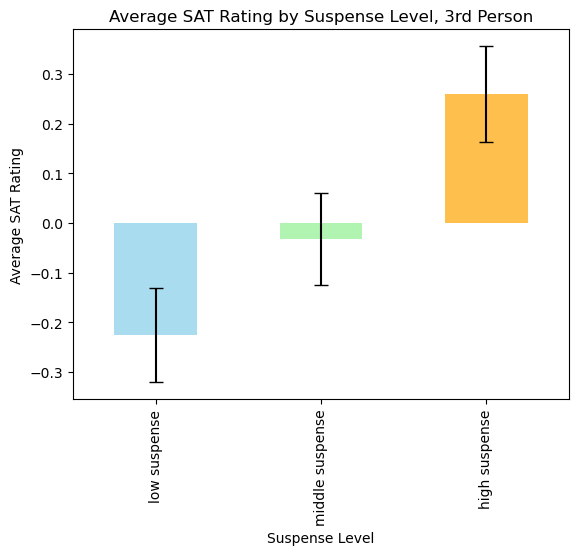

In [221]:
plot_sat_susp (sat_filtered_df)
#plot_sat_susp (sat_df_first_half)
#plot_sat_susp (sat_df_second_half)



In [222]:
def plot_sat_outcome (dataframe):

    # Group by 'suspense_level' and calculate the mean of 'sat_rating'
    grouped_df_count = dataframe.groupby('expected_outcome')['sat_rating'].count()

    grouped_df_mean = dataframe.groupby('expected_outcome')['sat_rating'].mean()

    grouped_df_sem = (dataframe.groupby('expected_outcome')['sat_rating'].std())/np.sqrt(grouped_df_count)

    # Plotting the bar plot
    ax = grouped_df_mean.plot(kind='bar', yerr=grouped_df_sem, capsize=5, color=['skyblue', 'lightgreen'], alpha=0.7)

    # Adding labels and title
    plt.xlabel('Game Outcome')
    plt.ylabel('Average SAT Rating')
    plt.title('Average SAT Rating by Game Outcome, 3rd Person')

    # Show the plot
    plt.show()

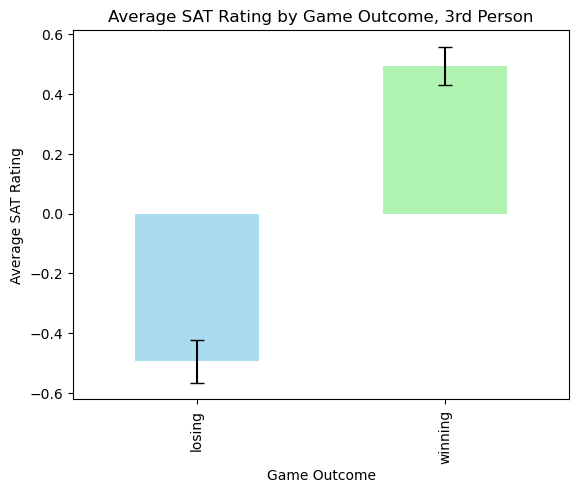

In [223]:
plot_sat_outcome (sat_filtered_df)
#plot_sat_outcome (sat_df_first_half)
#plot_sat_outcome (sat_df_second_half)

In [224]:
def plot_sat_susp_outcome(dataframe):
    # Calculate the sample size for each group
    grouped_df_count = dataframe.groupby(['suspense_level', 'expected_outcome'])['sat_rating'].count()

    # Group by both 'suspense_level' and 'expected_outcome' and calculate the mean and standard error of 'sat_rating'
    grouped_df_mean = dataframe.groupby(['suspense_level', 'expected_outcome'])['sat_rating'].mean()
    grouped_df_std = (dataframe.groupby(['suspense_level', 'expected_outcome'])['sat_rating'].std()) / np.sqrt(grouped_df_count)

    # Convert the result to a DataFrame for plotting
    grouped_df_mean = grouped_df_mean.unstack()
    grouped_df_sem = grouped_df_std.unstack()

    # Make sure order is low, mid, high
    grouped_df_mean = grouped_df_mean.reindex(['low suspense', 'middle suspense', 'high suspense'])
    grouped_df_sem = grouped_df_sem.reindex(['low suspense', 'middle suspense', 'high suspense'])

    print(grouped_df_mean)
    print(grouped_df_sem)

    # Plotting the bar plot with error bars as standard error (SEM)
    ax = grouped_df_mean.plot(kind='bar', yerr=grouped_df_sem, capsize=5, color=['skyblue', 'lightgreen'], alpha=0.7)

    # Adding labels and title
    plt.xlabel('Suspense Level', fontsize=13)
    plt.ylabel('Average SAT Rating (Z-scored)', fontsize=13)
    plt.ylim(-1.5, 1.5)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    # Perform one-sample t-tests for each group
    t_test_results = []
    for suspense_level in grouped_df_mean.index:
        for outcome in grouped_df_mean.columns:
            group_ratings = dataframe[(dataframe['suspense_level'] == suspense_level) & (dataframe['expected_outcome'] == outcome)]['sat_rating']
            t_stat, p_val = ttest_1samp(group_ratings, 0)
            t_test_results.append((f'{suspense_level} ({outcome} vs 0)', t_stat, p_val))
    
    # Display t-test results
    t_test_text = '\n'.join([f'{comparison}: t={t_stat:.2f}, adj-p={p_val:.2e}' for comparison, t_stat, p_val in t_test_results])
    print(t_test_text)

    # Perform ANOVA
    model = ols('sat_rating ~ C(suspense_level) * C(expected_outcome)', data=dataframe).fit()
    anova_results = anova_lm(model, typ=2)
    print("ANOVA results:\n", anova_results)

    # Perform Tukey's HSD test
    mc = pairwise_tukeyhsd(dataframe['sat_rating'], dataframe['suspense_level'] + ' ' + dataframe['expected_outcome'])
    print("Tukey's HSD results:\n", mc)

    # Collect all p-values for FDR correction
    p_values = [result[2] for result in t_test_results]

    # Apply FDR correction
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

    # Update t_test_results with corrected p-values
    for i, (comparison, t_stat, p_val) in enumerate(t_test_results):
        t_test_results[i] = (comparison, t_stat, pvals_corrected[i])

    
    
    # Perform pairwise t-test between "low suspense winning" and "high suspense winning"
    low_suspense_winning = dataframe[(dataframe['suspense_level'] == 'low suspense') & (dataframe['expected_outcome'] == 'winning')]['sat_rating']
    high_suspense_winning = dataframe[(dataframe['suspense_level'] == 'high suspense') & (dataframe['expected_outcome'] == 'winning')]['sat_rating']

    delta_means_low_high = low_suspense_winning.mean() - high_suspense_winning.mean()

    t_stat, p_val = ttest_ind(low_suspense_winning, high_suspense_winning)
    df_degree_freedom = len(low_suspense_winning) + len(high_suspense_winning) - 2
    print(f"Pairwise t-test results between low suspense winning and high suspense winning: t={t_stat:.2f}, df={df_degree_freedom}, p={p_val:.2e}, delta_means={delta_means_low_high:.2f}")

    # Perform pairwise t-test between "middle suspense winning" and "high suspense winning"
    middle_suspense_winning = dataframe[(dataframe['suspense_level'] == 'middle suspense') & (dataframe['expected_outcome'] == 'winning')]['sat_rating']
    high_suspense_winning = dataframe[(dataframe['suspense_level'] == 'high suspense') & (dataframe['expected_outcome'] == 'winning')]['sat_rating']

    delta_means_middle_high = middle_suspense_winning.mean() - high_suspense_winning.mean()

    t_stat, p_val = ttest_ind(middle_suspense_winning, high_suspense_winning)
    df_degree_freedom = len(middle_suspense_winning) + len(high_suspense_winning) - 2
    print(f"Pairwise t-test results between middle suspense winning and high suspense winning: t={t_stat:.2f}, df={df_degree_freedom}, p={p_val:.2e}, delta_means={delta_means_middle_high:.2f}")


expected_outcome    losing   winning
suspense_level                      
low suspense     -0.802468  0.349321
middle suspense  -0.433762  0.369350
high suspense    -0.243157  0.760715
expected_outcome    losing   winning
suspense_level                      
low suspense      0.096258  0.116271
middle suspense   0.129322  0.107393
high suspense     0.132721  0.100545
low suspense (losing vs 0): t=-8.34, adj-p=5.04e-11
low suspense (winning vs 0): t=3.00, adj-p=4.15e-03
middle suspense (losing vs 0): t=-3.35, adj-p=1.53e-03
middle suspense (winning vs 0): t=3.44, adj-p=1.19e-03
high suspense (losing vs 0): t=-1.83, adj-p=7.29e-02
high suspense (winning vs 0): t=7.57, adj-p=7.84e-10
ANOVA results:
                                            sum_sq     df           F  \
C(suspense_level)                       12.172612    2.0    9.090661   
C(expected_outcome)                     74.411864    1.0  111.143453   
C(suspense_level):C(expected_outcome)    1.561954    2.0    1.166487   
Residu

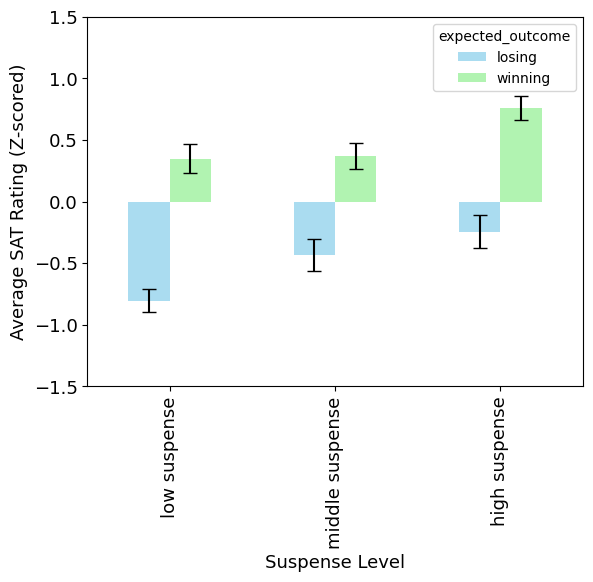

In [225]:
plot_sat_susp_outcome (sat_filtered_df)
#plot_sat_susp_outcome (sat_df_first_half)
#plot_sat_susp_outcome (sat_df_second_half)

expected_outcome    losing   winning
suspense_level                      
low suspense     -0.835797  0.520975
middle suspense  -0.434440  0.528562
high suspense    -0.211095  0.407604
expected_outcome    losing   winning
suspense_level                      
low suspense      0.118199  0.130725
middle suspense   0.099672  0.121622
high suspense     0.133118  0.129697
low suspense (losing vs 0): t=-7.07, adj-p=8.99e-09
low suspense (winning vs 0): t=3.99, adj-p=2.50e-04
middle suspense (losing vs 0): t=-4.36, adj-p=7.75e-05
middle suspense (winning vs 0): t=4.35, adj-p=6.31e-05
high suspense (losing vs 0): t=-1.59, adj-p=1.20e-01
high suspense (winning vs 0): t=3.14, adj-p=3.40e-03
ANOVA results:
                                            sum_sq     df          F  \
C(suspense_level)                        3.582791    2.0   2.630518   
C(expected_outcome)                     66.035750    1.0  96.968099   
C(suspense_level):C(expected_outcome)    5.801525    2.0   4.259532   
Residual  

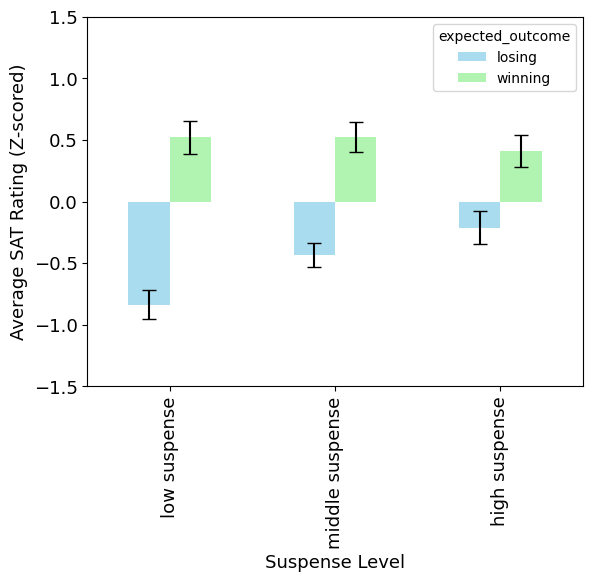

In [226]:
plot_sat_susp_outcome(sat_filtered_df_1st)

In [227]:
#Save sat_filtered_df

sat_filtered_df

# Save the DataFrame to Excel
sat_filtered_df.to_excel('sat_filtered_df_3rd_Bastien.xlsx', index=False)

In [228]:
#compare in two-sample t-test winning and losing across agency conditions
from scipy import stats


# Filter satisfaction ratings for winning outcomes
sat_win_df = sat_filtered_df[sat_filtered_df['expected_outcome'] == 'winning']['sat_rating']
sat_win_df_1st = sat_filtered_df_1st[sat_filtered_df_1st['expected_outcome'] == 'winning']['sat_rating']

# Filter satisfaction ratings for losing outcomes
sat_lose_df = sat_filtered_df[sat_filtered_df['expected_outcome'] == 'losing']['sat_rating']
sat_lose_df_1st = sat_filtered_df_1st[sat_filtered_df_1st['expected_outcome'] == 'losing']['sat_rating']

# Perform two-sample t-test for winning outcomes
t_stat_win, p_value_win = stats.ttest_ind(sat_win_df, sat_win_df_1st)

# Perform two-sample t-test for losing outcomes
t_stat_lose, p_value_lose = stats.ttest_ind(sat_lose_df, sat_lose_df_1st)

# Print results
print(f"T-test for winning outcomes across agency conditions: t-statistic = {t_stat_win}, p-value = {p_value_win}")
print(f"T-test for losing outcomes across agency conditions: t-statistic = {t_stat_lose}, p-value = {p_value_lose}")



#Filter specifically for winning and high_suspense


# Filter satisfaction ratings for high suspense level and winning outcomes
sat_high_suspense_win_df = sat_filtered_df[(sat_filtered_df['expected_outcome'] == 'winning') & (sat_filtered_df['suspense_level'] == 'high suspense')]['sat_rating']
sat_high_suspense_win_df_1st = sat_filtered_df_1st[(sat_filtered_df_1st['expected_outcome'] == 'winning') & (sat_filtered_df_1st['suspense_level'] == 'high suspense')]['sat_rating']

# Perform two-sample t-test for high suspense level in winning outcomes
t_stat_high_suspense_win, p_value_high_suspense_win = stats.ttest_ind(sat_high_suspense_win_df, sat_high_suspense_win_df_1st)

# Print results
print(f"T-test for high suspense level in winning outcomes across agency conditions: t-statistic = {t_stat_high_suspense_win}, p-value = {p_value_high_suspense_win}")



T-test for winning outcomes across agency conditions: t-statistic = -0.006689861629403123, p-value = 0.9946669664165404
T-test for losing outcomes across agency conditions: t-statistic = 0.006398064460968479, p-value = 0.9948995784481518
T-test for high suspense level in winning outcomes across agency conditions: t-statistic = 2.182082674779518, p-value = 0.031862982913841806


In [229]:
# Degrees of freedom for the two-sample t-test for winning outcomes
df_win = len(sat_win_df) + len(sat_win_df_1st) - 2

# Degrees of freedom for the two-sample t-test for losing outcomes
df_lose = len(sat_lose_df) + len(sat_lose_df_1st) - 2

# Degrees of freedom for the two-sample t-test for high suspense level in winning outcomes
df_high_suspense_win = len(sat_high_suspense_win_df) + len(sat_high_suspense_win_df_1st) - 2

# Print the degrees of freedom
print(f"Degrees of freedom for winning outcomes: {df_win}")
print(f"Degrees of freedom for losing outcomes: {df_lose}")
print(f"Degrees of freedom for high suspense level in winning outcomes: {df_high_suspense_win}")

Degrees of freedom for winning outcomes: 286
Degrees of freedom for losing outcomes: 286
Degrees of freedom for high suspense level in winning outcomes: 85


In [230]:

def plot_sat_susp_outcome2(dataframe1, dataframe2):

    pastel_palette = sns.color_palette("pastel")

    # Calculate the sample size for each group in dataframe1
    grouped_df_count1 = dataframe1.groupby(['suspense_level', 'expected_outcome'])['sat_rating'].count()

    # Group by both 'suspense_level' and 'expected_outcome' and calculate the mean and standard error of 'sat_rating' for dataframe1
    grouped_df_mean1 = dataframe1.groupby(['suspense_level', 'expected_outcome'])['sat_rating'].mean()
    grouped_df_std1 = (dataframe1.groupby(['suspense_level', 'expected_outcome'])['sat_rating'].std()) / np.sqrt(grouped_df_count1)

    # Calculate the sample size for each group in dataframe2
    grouped_df_count2 = dataframe2.groupby(['suspense_level', 'expected_outcome'])['sat_rating'].count()

    # Group by both 'suspense_level' and 'expected_outcome' and calculate the mean and standard error of 'sat_rating' for dataframe2
    grouped_df_mean2 = dataframe2.groupby(['suspense_level', 'expected_outcome'])['sat_rating'].mean()
    grouped_df_std2 = (dataframe2.groupby(['suspense_level', 'expected_outcome'])['sat_rating'].std()) / np.sqrt(grouped_df_count2)

    # Convert the results to DataFrames for plotting
    grouped_df_mean1 = grouped_df_mean1.unstack()
    grouped_df_sem1 = grouped_df_std1.unstack()

    grouped_df_mean2 = grouped_df_mean2.unstack()
    grouped_df_sem2 = grouped_df_std2.unstack()

    # Make sure order is low, mid, high
    grouped_df_mean1 = grouped_df_mean1.reindex(['low suspense', 'middle suspense', 'high suspense'])
    grouped_df_sem1 = grouped_df_sem1.reindex(['low suspense', 'middle suspense', 'high suspense'])

    grouped_df_mean2 = grouped_df_mean2.reindex(['low suspense', 'middle suspense', 'high suspense'])
    grouped_df_sem2 = grouped_df_sem2.reindex(['low suspense', 'middle suspense', 'high suspense'])

     

    # Plotting the bar plot with error bars as standard error (SEM) for dataframe1
    ax = grouped_df_mean1.plot(kind='bar', yerr=grouped_df_sem1, capsize=5, color=pastel_palette[9], alpha=0.9, position=-0.5, width=0.4)


    # Plotting the bar plot with error bars as standard error (SEM) for dataframe2
    grouped_df_mean2.plot(kind='bar', yerr=grouped_df_sem2, capsize=5, color=pastel_palette[4], alpha=0.9, ax=ax, position=0.5, width=0.4)

    # Add hatch to bars corresponding to losing games in dataframe1
    #bars[('sat_rating', 'losing')].get_children()[0].set_hatch('//')  # Example: Apply hatch to the first losing bar in dataframe2


    # Removing the legend
    ax.legend().remove()

    # Adding labels and title
    plt.xlabel('Suspense Level', fontsize=13)
    plt.ylabel('Average SAT Rating (Z-scored)', fontsize=13)
    plt.ylim(-1.5, 1.5)
    plt.xlim(-0.3, 2.7)
    plt.xticks([], [])
    plt.yticks(fontsize=13)

    plt.show()  # Show the plot


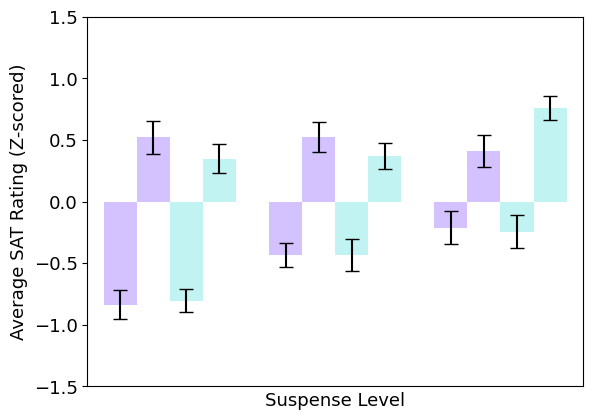

In [231]:
plot_sat_susp_outcome2(sat_filtered_df, sat_filtered_df_1st)

In [232]:
# Merge DataFrames based on 'Game_index'
merged_df = pd.merge(sat_df, suspense_sum, on='game', how='left')

# Fill the 'suspense' column with 'Suspense_sum' values
merged_df['suspense'] = merged_df['suspense_sum'].fillna(0)

# Drop the 'Suspense_sum' column if no longer needed
merged_df = merged_df.drop(columns='suspense_sum')



Text(0.5, 1.0, 'Suspense Vs Satisfaction')

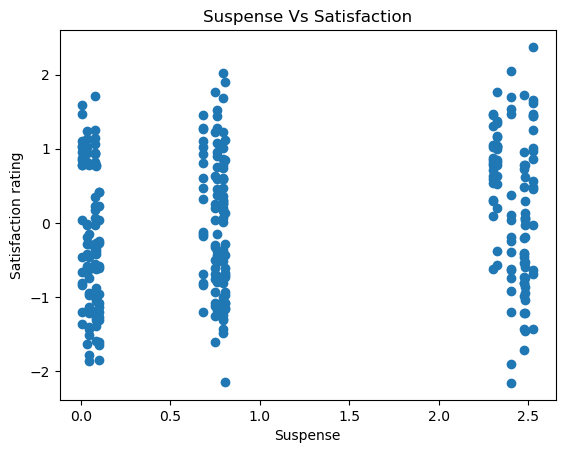

In [233]:
x = merged_df['suspense']
y = merged_df['sat_rating']

plt.scatter(x,y)

plt.xlabel('Suspense')
plt.ylabel('Satisfaction rating')
plt.title('Suspense Vs Satisfaction')

#### Linear Models

In [234]:
# Get unique participant IDs
participants_sat_df = sat_filtered_df['participant'].unique()
participants_susp_df = susp_filtered_df_3rd['participant'].unique()


# Create a dictionary to store DataFrames for each participant
participant_dfs_sat = {}
participant_dfs_susp = {}

# Iterate over each participant
for participant_sat, participant_susp in zip(participants_sat_df, participants_susp_df):
    # Filter data for the current participant
    participant_df_sat = sat_filtered_df[sat_filtered_df['participant'] == participant_sat].copy()
    
    # Store the DataFrame for the current participant in the dictionary
    participant_dfs_sat[participant_sat] = participant_df_sat


    #extract suspense ratings and store them
    participant_df_susp = susp_filtered_df_3rd[susp_filtered_df_3rd['participant'] == participant_susp].copy()
    participant_dfs_susp[participant_susp] = participant_df_susp




In [235]:
#Compute linear model comparing satisfaction ratings and suspense sum

# Create a dictionary to store DataFrames for each participant
participant_models = {}
participant_param = {}

avg_susp_per_game = susp_filtered_df_3rd.groupby(['game'])['susp_rating'].mean().reset_index(drop=True)


#first compute 17 different models (1 per participant)
for participant_susp, participant_sat in zip(participant_dfs_susp, participant_dfs_sat):
    #extract suspense rating per participant for each round per game

    #extract satisfaction per game
    sat = participant_dfs_sat[participant_sat]['sat_rating'].reset_index(drop=True)


    #Extract outcome per game
    outcome = participant_dfs_sat[participant_sat]['expected_outcome'].reset_index(drop=True)
    

    # Combine the Series into a single DataFrame
    model_df_1st = pd.DataFrame({
        'satisfaction': sat,
        'suspense': avg_susp_per_game,
        'outcome': outcome
    })


    # Encode the categorical outcome variable
    model_df_1st['outcome_encoded'] = model_df_1st['outcome'].map({'losing': 0, 'winning': 1})


    # Create the interaction term
    model_df_1st['suspense_outcome_interaction'] = model_df_1st['suspense'] * model_df_1st['outcome_encoded']


    # Define the dependent variable
    y = model_df_1st['satisfaction']

    # Define the independent variables
    X = model_df_1st[['suspense', 'outcome_encoded', 'suspense_outcome_interaction']]

    # Add a constant to the independent variables (for the intercept)
    X = sm.add_constant(X)

    # Create and fit the OLS model
    model_sat_1st_part = sm.OLS(y, X).fit()

    # Save model results to a file to compare with other model
    model_sat_1st = {
        "params": model_sat_1st_part.params.tolist(),
        "llf": model_sat_1st_part.llf,
        "aic": model_sat_1st_part.aic,
        "bic": model_sat_1st_part.bic,
        "std_err": model_sat_1st_part.bse.tolist()
    }


    participant_models[participant_sat] = model_sat_1st_part
    participant_param[participant_sat] = model_sat_1st



In [236]:
#Now check if there are statistical differences between a distribution of slopes centred around 0 and the distribution of slopes in our data
all_slopes_susp = []
all_slopes_outcome = []
all_slopes_int = []
all_const = []
for participant in participant_param:
    const = participant_param[participant]['params'][0]
    slope_susp = participant_param[participant]['params'][1]
    slope_outcome = participant_param[participant]['params'][2]
    slope_susp_and_outcome = participant_param[participant]['params'][3]
    
    all_slopes_susp.append(slope_susp)
    all_slopes_outcome.append(slope_outcome)
    all_slopes_int.append(slope_susp_and_outcome)

    all_const.append(const)



null_distribution = np.random.randn(10000000)


#save slopes from 3rd person to compare with model of 1st person

with open('all_slopes_susp_3rd.json', 'w') as f:
    json.dump(all_slopes_susp, f)

with open('all_slopes_outcome_3rd.json', 'w') as f:
    json.dump(all_slopes_outcome, f)

with open('all_slopes_int_3rd.json', 'w') as f:
    json.dump(all_slopes_int, f)



In [237]:
#divide suspense games results by winning or losing outcomes:

participant_dfs_susp_win = {}
participant_dfs_susp_lose = {}

participant_dfs_sat_win = {}
participant_dfs_sat_lose = {}

# Iterate over each participant in participant_dfs_susp
for participant_susp, participant_sat in zip(participant_dfs_susp, participant_dfs_sat):
    # Filter the DataFrame for the current participant where expected outcome is 'winning'
    participant_dfs_susp_win[participant_susp] = participant_dfs_susp[participant_susp][participant_dfs_susp[participant_susp]['expected_outcome'] == 'winning']
    participant_dfs_susp_lose[participant_susp] = participant_dfs_susp[participant_susp][participant_dfs_susp[participant_susp]['expected_outcome'] == 'losing']

    participant_dfs_sat_win[participant_sat] = participant_dfs_sat[participant_sat][participant_dfs_sat[participant_sat]['expected_outcome'] == 'winning']
    participant_dfs_sat_lose[participant_sat] = participant_dfs_sat[participant_sat][participant_dfs_sat[participant_sat]['expected_outcome'] == 'losing']






In [238]:
#Compute linear model comparing satisfaction ratings and suspense sum for different outcomes

# Create a dictionary to store DataFrames for each participant
participant_models_win = {}
participant_param_win = {}

participant_models_lose = {}
participant_param_lose = {}


avg_susp_per_game_win = susp_filtered_df_3rd[susp_filtered_df_3rd['expected_outcome']=='winning'].groupby(['game'])['susp_rating'].mean().reset_index(drop=True)
avg_susp_per_game_lose = susp_filtered_df_3rd[susp_filtered_df_3rd['expected_outcome']=='losing'].groupby(['game'])['susp_rating'].mean().reset_index(drop=True)

#first compute 17 different models (1 per participant)
for participant_susp, participant_sat in zip(participant_dfs_susp, participant_dfs_sat):
    #extract suspense rating per participant for each round per game

    #extract satisfaction per game
    sat_win = participant_dfs_sat_win[participant_sat]['sat_rating'].reset_index(drop=True)
    sat_lose = participant_dfs_sat_lose[participant_sat]['sat_rating'].reset_index(drop=True)


    # Combine the Series into a single DataFrame
    model_df_3rd_win = pd.DataFrame({
        'satisfaction': sat_win,
        'suspense': avg_susp_per_game_win,
    })


      # Combine the Series into a single DataFrame
    model_df_3rd_lose = pd.DataFrame({
        'satisfaction': sat_lose,
        'suspense': avg_susp_per_game_lose,
    })


    # Define the dependent variable
    y_win = model_df_3rd_win['satisfaction']
    y_lose = model_df_3rd_win['satisfaction']

    # Define the independent variables
    X_win = model_df_3rd_win[['suspense']]
    X_lose = model_df_3rd_lose[['suspense']]

    # Add a constant to the independent variables (for the intercept)
    X_win= sm.add_constant(X_win)

    # Add a constant to the independent variables (for the intercept)
    X_lose = sm.add_constant(X_lose)

    # Create and fit the OLS model
    model_sat_3rd_part_win = sm.OLS(y_win, X_win).fit()
    model_sat_3rd_part_lose = sm.OLS(y_lose, X_lose).fit()

    # Save model results to a file to compare with other model
    model_sat_3rd_win = {
        "params": model_sat_3rd_part_win.params.tolist(),
        "llf": model_sat_3rd_part_win.llf,
        "aic": model_sat_3rd_part_win.aic,
        "bic": model_sat_3rd_part_win.bic,
        "std_err": model_sat_3rd_part_win.bse.tolist()
    }


    # Save model results to a file to compare with other model
    model_sat_3rd_lose = {
        "params": model_sat_3rd_part_lose.params.tolist(),
        "llf": model_sat_3rd_part_lose.llf,
        "aic": model_sat_3rd_part_lose.aic,
        "bic": model_sat_3rd_part_lose.bic,
        "std_err": model_sat_3rd_part_lose.bse.tolist()
    }


    participant_models_win[participant_sat] = model_sat_3rd_part_win
    participant_param_win[participant_sat] = model_sat_3rd_win
    participant_models_lose[participant_sat] = model_sat_3rd_part_lose
    participant_param_lose[participant_sat] = model_sat_3rd_lose



In [239]:
all_r_squared_win=[]
all_r_squared_lose=[]

for participant_win, participant_lose in zip(participant_models_win, participant_models_lose):
    r_squared_win = participant_models_win[participant_win].rsquared
    all_r_squared_win.append(r_squared_win)

    r_squared_lose = participant_models_lose[participant_lose].rsquared
    all_r_squared_lose.append(r_squared_lose)

mean_r_squared_win = np.mean(all_r_squared_win)
mean_r_squared_lose = np.mean(all_r_squared_lose)

print(mean_r_squared_win)
print(mean_r_squared_lose)

0.21654712701070514
0.21034296050765205


In [255]:
all_r_squared_win

[0.32593790651201904,
 0.016054792096001802,
 0.15223114381942127,
 0.3487483101529786,
 0.3452277251217738,
 0.45528592456008443,
 0.0002010400855798622,
 0.010519764964723177,
 0.045928589302029366,
 0.6012082883703023,
 0.032694642505095795,
 0.020535717452018654,
 0.18206895744073215,
 0.6018775994903987,
 0.01048432860232551,
 0.0029541185288359806,
 0.5293423101776673]

In [240]:
#Now check if there are statistical differences between a distribution of slopes centred around 0 and the distribution of slopes in our data
all_slopes_susp_win = []
all_slopes_susp_lose = []
all_const_win = []
all_const_lose = []

for participant_win, participant_lose in zip(participant_param_win, participant_param_lose):
    const_win = participant_param_win[participant_win]['params'][0]
    const_lose = participant_param_lose[participant_lose]['params'][0]

    slope_susp_win = participant_param_win[participant_win]['params'][1]
    slope_susp_lose = participant_param_lose[participant_lose]['params'][1]

    all_slopes_susp_win.append(slope_susp_win)
    all_slopes_susp_lose.append(slope_susp_lose)

    
    all_const_win.append(const_win)
    all_const_lose.append(const_lose)



null_distribution = np.random.randn(10000000)


#save slopes from 3rd person to compare with model of 1st person

with open('all_slopes_susp_3rd_win.json', 'w') as f:
    json.dump(all_slopes_susp_win, f)

with open('all_slopes_susp_3rd_lose.json', 'w') as f:
    json.dump(all_slopes_susp_lose, f)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

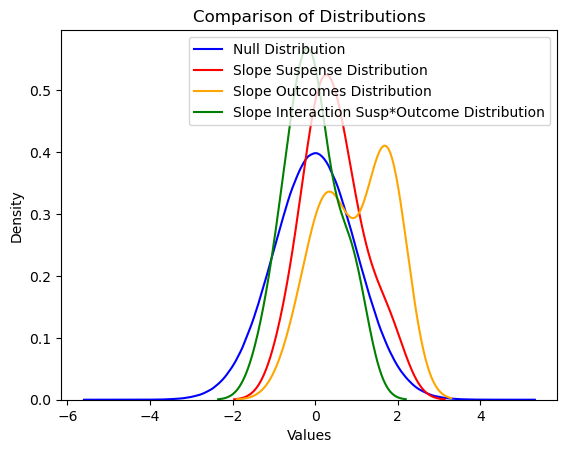

In [241]:
# Plot the KDE curve for null distribution
sns.kdeplot(null_distribution, color='blue', label='Null Distribution')

# Plot the KDE curve for distribution of slopes
sns.kdeplot(all_slopes_susp, color='red', label='Slope Suspense Distribution')

# Plot the KDE curve for distribution of slopes
sns.kdeplot(all_slopes_outcome, color='orange', label='Slope Outcomes Distribution')

sns.kdeplot(all_slopes_int, color='green', label='Slope Interaction Susp*Outcome Distribution')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Comparison of Distributions')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [242]:
from scipy import stats

In [243]:
# List of slope sets to compare
slope_sets = {
    'Suspense Slopes': all_slopes_susp,
    'Outcome Slopes': all_slopes_outcome,
    'Interaction Slopes': all_slopes_int
}

# Perform t-test for each set of slopes
alpha = 0.05
t_test_results = {}

for name, slopes in slope_sets.items():
    t_statistic, p_value = stats.ttest_1samp(slopes, 0)
    t_test_results[name] = (t_statistic, p_value)
    print(f"T-test for {name}:")
    print(f"T-statistic: {t_statistic}, P-value: {p_value}")
    if p_value < alpha:
        print("The two distributions are significantly different.\n")
    else:
        print("The two distributions are not significantly different.\n")

# Plotting the distributions for visual comparison
plt.figure(figsize=(14, 7))


T-test for Suspense Slopes:
T-statistic: 2.650690701111432, P-value: 0.01744459502092131
The two distributions are significantly different.

T-test for Outcome Slopes:
T-statistic: 4.892386577896939, P-value: 0.00016269555463149435
The two distributions are significantly different.

T-test for Interaction Slopes:
T-statistic: -0.46058162848975603, P-value: 0.6512969010668629
The two distributions are not significantly different.



<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

In [244]:
# Convert 'outcome' column into dummy variables


# Add constant to the independent variables matrix (required for the intercept)
X = merged_df['suspense']
y = merged_df['sat_rating']

# Create and fit the linear regression model
model = sm.OLS(y, X).fit()

In [245]:
# Print model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:             sat_rating   R-squared (uncentered):                   0.017
Model:                            OLS   Adj. R-squared (uncentered):              0.014
Method:                 Least Squares   F-statistic:                              5.245
Date:                Fri, 07 Jun 2024   Prob (F-statistic):                      0.0227
Time:                        18:57:28   Log-Likelihood:                         -422.84
No. Observations:                 306   AIC:                                      847.7
Df Residuals:                     305   BIC:                                      851.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [246]:

def plot_sat_trajectory(dataframe):
    # Group by 'suspense_level' and 'game', and calculate the mean and standard error of 'sat_rating'
    grouped_df_count = dataframe.groupby(['game', 'suspense_level'])['sat_rating'].count()
    grouped_df_mean = dataframe.groupby(['game', 'suspense_level'])['sat_rating'].mean().reset_index()
    grouped_df_std = (dataframe.groupby(['game', 'suspense_level'])['sat_rating'].std())/np.sqrt(grouped_df_count)



    # Plotting the bar plot
    sns.barplot(data=grouped_df_mean, x='game', y='sat_rating', hue='suspense_level',
                yerr=grouped_df_std, alpha=0.9, palette='muted', dodge=False)

    # Adding labels and title
    plt.xlabel('Game Number')
    plt.ylabel('Average SAT Rating')
    plt.title('Average SAT Rating by Game Number')

    # Show the plot
    plt.legend(title='Suspense Level', loc='lower right')
    plt.show()

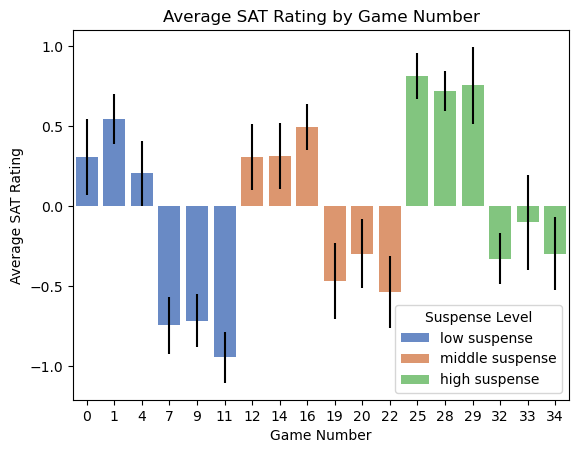

In [247]:
plot_sat_trajectory(sat_df)

In [248]:

def plot_sat_trajectory_median(dataframe):
    # Group by 'suspense_level' and 'game', and calculate the mean and standard error of 'sat_rating'
    grouped_df_count = dataframe.groupby(['game', 'suspense_level'])['sat_rating'].count()
    grouped_df_median= dataframe.groupby(['game', 'suspense_level'])['sat_rating'].median().reset_index()
    grouped_df_std = (dataframe.groupby(['game', 'suspense_level'])['sat_rating'].std())/np.sqrt(grouped_df_count)



    # Plotting the bar plot
    sns.barplot(data=grouped_df_median, x='game', y='sat_rating', hue='suspense_level',
                yerr=grouped_df_std, alpha=0.9, palette='muted', dodge=False)

    # Adding labels and title
    plt.xlabel('Game Number')
    plt.ylabel('Median SAT Rating')
    plt.title('Median SAT Rating by Game Number')

    # Show the plot
    plt.legend(title='Suspense Level', loc='lower right')
    plt.show()

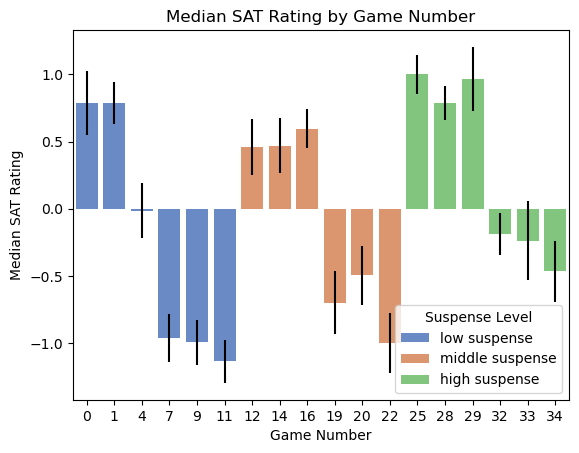

In [249]:
plot_sat_trajectory_median(sat_df)

what if there is a difference if the penultime round is going over or under the threhsold (difference in gane 28 and 29?)

group satisfaction by whether the penultime count is over the threshold or under the threshold

In [250]:
filtered_df.head()

#if count at pair_number 4 > 3 
#group sat_rating at pair_number 5 in post-threshold


#if count at pair_number 4 < 3 
#group sat_rating at pair_number 5 in pre-threshold


,rt,catch_response,sat_rating,trial,game,pair_number,card_1,card_2,count,catch_count,catch_count_response,expected_outcome,suspense_level,participant,success_rate
895,5780,1,NaN,17,0,1,-6,1,-6,NaN,NaN,winning,low suspense,Participant10,90.0
896,3645,0,NaN,17,0,2,1,-4,-5,NaN,NaN,winning,low suspense,Participant10,90.0
897,2759,3,NaN,17,0,3,-5,-4,-10,NaN,NaN,winning,low suspense,Participant10,90.0
898,2278,0,NaN,17,0,4,1,-3,-13,-13.0,1.0,winning,low suspense,Participant10,90.0
899,5240,0,1.109212,17,0,5,1,-4,-17,NaN,NaN,winning,low suspense,Participant10,90.0


In [251]:
def pre_post_threshold (dataframe):

    
    condition_1 = (dataframe['pair_number'] == 4) & (dataframe['count'] <= 3)
    #condition_2 = (dataframe['pair_number'] == 4) & (dataframe['count'] > 3)

    conditions = [condition_1]

    choices = [True]


    dataframe['ascending'] = np.select (conditions, choices) 

    #filter onto df based on condition
    row_4_df = dataframe.loc[(dataframe['pair_number'] == 4)].copy()

    ascending_games = row_4_df.loc[row_4_df['ascending']==True]['game'].unique()
    descending_games = row_4_df.loc[row_4_df['ascending']==False]['game'].unique()



    return ascending_games, descending_games

            

In [252]:
ascending_games, descending_games = pre_post_threshold(filtered_df)

print(descending_games)

print(ascending_games)


[ 7  9 11 19 20 29 32 33]
[ 0  1  4 12 14 16 22 25 28 34]


In [253]:
def add_pre_threshold (dataframe, ascending, descending):

    condition_1 = (dataframe['game'].isin(ascending))
    condition_2 = (dataframe['game'].isin(descending))

    conditions = [condition_1, condition_2]

    choices = [True, False]


    dataframe['ascending'] = np.select (conditions, choices) 

    return dataframe


In [254]:
add_pre_threshold(sat_df, ascending_games, descending_games)

sat_df.loc[sat_df['ascending']==0]

,sat_rating,game,expected_outcome,suspense_level,participant,ascending
839,-1.083416,7,losing,low suspense,Participant10,0
874,-1.186599,9,losing,low suspense,Participant10,0
849,-1.160803,11,losing,low suspense,Participant10,0
829,-0.928642,19,losing,middle suspense,Participant10,0
869,-1.083416,20,losing,middle suspense,Participant10,0
...,...,...,...,...,...,...
799,-1.085161,19,losing,middle suspense,Participant9,0
804,-0.496002,20,losing,middle suspense,Participant9,0
734,0.455717,29,winning,high suspense,Participant9,0
794,-0.949201,32,losing,high suspense,Participant9,0
